In [1]:
from nltk.corpus import gutenberg # to get bible corpus
from string import punctuation  # to remove punctuation from corpus
import nltk 
import numpy as np
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams 
from keras.layers import *
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model,Sequential 
from sklearn.decomposition import PCA
import re
import torch
import json
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

# Data Prepare

### Prepare Corpus

In [ ]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
bible = gutenberg.sents("bible-kjv.txt")
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
    doc = doc.lower()
    doc = doc.strip() 
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
normalize_corpus = np.vectorize(normalize_document)
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}


vocab_size = len(word2id) + 1
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:5]) 

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5)]


In [ ]:
 # generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]
 # view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
           id2word[pairs[i][1]], pairs[i][1], 
           labels[i])) 

(bible (5766), palsies (11692)) -> 0
(james (1154), bible (5766)) -> 1
(james (1154), king (13)) -> 1
(bible (5766), king (13)) -> 1
(king (13), james (1154)) -> 1
(james (1154), languisheth (3905)) -> 0
(bible (5766), james (1154)) -> 1
(bible (5766), thyatira (5733)) -> 0
(king (13), corrupteth (11553)) -> 0
(king (13), bible (5766)) -> 1


### Prepare Word Embeddings from BERT

In [ ]:
from google.colab import drive
import os
import sys

drive.mount("/content/drive")


GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'debiasingGAN'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.ipynb_checkpoints', 'bert-base-uncased-embeddings.txt', 'discriminator.pt', 'debiasNet-2.ipynb', 'y.pt', 'x.pt', 'pairLabelSet.json', 'dataIdxSet.json', 'pairIdxSet.json', 'generator_0.pt', 'generator_1.pt', 'generator_2.pt', 'neutral_tokens.npy', 'male_bias_sensitive_tokens.npy', 'female_bias_sensitive_tokens.npy', 'debiasNet.ipynb', 'embeddings-before-null-projection.png', 'embeddings-after-null-projection.png', 'questions-words.txt', 'processed_embedding.txt', 'generator_3.pt', 'bert-embeddings.txt', 'debiasingNet2.ipynb']


In [ ]:
!pip install transformers
import numpy as np
from tqdm import tqdm
from transformers import (
    BertTokenizer,
    BertForMaskedLM
)
import pandas as pd
import torch
from torch.nn import functional as F
from transformers import logging

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_mlm = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

BERT_BIAS_LAYER = 12

def chunker(input_list, chunk_size):
    """split sequence into chunks"""
    for i in range(0, len(input_list), chunk_size):
        yield input_list[i:i + chunk_size]
        
def get_embeddings(input_sequences, model, tokenizer):
    """extract hidden state from nth attention layer in encoder as specified by BERT_BIAS_LAYER"""
    tokenized_input = bert_tokenizer.batch_encode_plus(input_sequences, return_tensors = "pt", padding=True, truncation=False)
    embeddings = bert_mlm(**tokenized_input, output_hidden_states=True).hidden_states[BERT_BIAS_LAYER]
    return embeddings.detach().numpy(), tokenized_input["input_ids"].detach().numpy()

def extract_token_embeddings(embeddings, input_ids):
    """filter special token embeddings"""
    extracted_embeddings = []
    for idx in range(embeddings.shape[0]):
        if 0 in input_ids[idx]: # if input contains padding
            eos_idx = list(input_ids[idx]).index(0) - 1
        else:
            eos_idx = list(input_ids[idx]).index(102)
        extracted_embeddings.append(embeddings[idx][1:eos_idx].mean(axis=0))
    return np.array(extracted_embeddings)

VOCAB = list(word2id.keys())

bert_vocab_embedding_list = np.empty((0, 768))
for chunk in tqdm(chunker(VOCAB, 1000)):
    embeddings, input_ids = get_embeddings(chunk, bert_mlm, bert_tokenizer)
    embeddings = extract_token_embeddings(embeddings, input_ids)
    bert_vocab_embedding_list = np.concatenate((bert_vocab_embedding_list, embeddings), axis=0)

EMBEDDINGS_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/bert-base-uncased-embeddings.txt"
embedding_shape = bert_vocab_embedding_list.shape
with open(EMBEDDINGS_FILE_PATH, "w") as bert_file:
    bert_file.write(f"{embedding_shape[0]} {embedding_shape[1]}\n")
    for word, embedding in zip(VOCAB, bert_vocab_embedding_list):
        bert_file.write(f"{word} {' '.join(map(str, list(embedding)))}\n")

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 6.5 MB 47.7 MB/s 
     |████████████████████████████████| 895 kB 45.6 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 59.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
13it [03:08, 14.53s/it]


In [ ]:
EMBEDDINGS_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/bert-base-uncased-embeddings.txt"
from gensim.models import KeyedVectors
embed = KeyedVectors.load_word2vec_format(EMBEDDINGS_FILE_PATH, binary=False)
print(len(embed.vocab))

12424


### Data Labeling

In [ ]:

TOP_N=1000
NUM_PCA_COMPONENTS=10
PAIRS = [["woman", "man"], ["girl", "boy"], ["mother", "father"], ["daughter", "son"],
         ["female", "male"],  ["mary", "john"]]


def doPCA(pairs, num_components=10):
    matrix = []
    for a, b in pairs:
        center = (a + b) / 2
        norm_a = a - center
        norm_b = b - center
        matrix.append(norm_a)
        matrix.append(norm_b)
    matrix = np.array(matrix)
    pca = PCA(n_components=num_components, svd_solver="full")
    pca.fit(matrix)
    return pca


def bias_subspace(embed, num_components=None):
    # define gender direction
    pair = []
    for p in PAIRS:
      if p[0] in embed.vocab and p[1] in embed.vocab:
        pair.append((embed[p[0]], embed[p[1]]))
      else:
        print(p)
    pca = doPCA(pair)
    bias_direction = pca.components_[0] # using principle component that has the highest variance in gender bias subspace
    print(f"pca explained variance ratio: {pca.explained_variance_ratio_} \n")
    
    return bias_direction



bias_direction = bias_subspace(embed=embed, num_components=NUM_PCA_COMPONENTS)
bias_sign = bias_direction.dot(embed["woman"] - embed["man"])
bias_direction = -bias_direction if bias_sign > 0 else bias_direction

group1 = embed.similar_by_vector(bias_direction, topn=TOP_N, restrict_vocab=None) # male biased
group2 = embed.similar_by_vector(-bias_direction, topn=TOP_N, restrict_vocab=None) # female biased
group3 = embed.similar_by_vector(np.array([0]*embed.vector_size), topn=TOP_N, restrict_vocab=None) # neutral tokens
male_tokens, male_scores = list(zip(*group1))
female_tokens, female_scores = list(zip(*group2))

word2label = {word:1 for word in embed.vocab}
for word in male_tokens:
  word2label[word] = 2
for word in female_tokens:
  word2label[word] = 0

pca explained variance ratio: [3.06400836e-01 2.59915054e-01 1.42808557e-01 1.20102994e-01
 9.39623639e-02 7.68102333e-02 1.42284594e-14 9.40959668e-15
 3.72876312e-15 2.26969869e-15] 



### Build DataSet

In [ ]:
X = torch.zeros(12425,768)
y = torch.zeros(12425)

count = 0
for i in range(1,len(id2word)+1):
  word = id2word[i]
  if word not in embed.vocab:
    # print("lost word:", i, word)
    continue
  else:
    X[i] = torch.tensor(embed[word])
    y[i] = word2label[word]
    count += 1
print("total valid word", count)

dataIdxSet = []
pairIdxSet = []
pairLabelSet = []
for i, subgram in enumerate(skip_grams):
  pair_first_idx = list(list(zip(*subgram[0]))[0])
  pair_second_idx = list(list(zip(*subgram[0]))[1])
  context_labels = subgram[1]

  idx_set = list(set(pair_first_idx + pair_second_idx))

  first_list = []
  for elt in pair_first_idx:
    first_list.append(idx_set.index(elt))
  second_list = []
  for elt in pair_second_idx:
    second_list.append(idx_set.index(elt))

  dataIdxSet.append(idx_set)
  pairIdxSet.append([first_list, second_list])
  pairLabelSet.append(context_labels)

# Resulting Dataset:
  # X[idx]: word embedding
  # y[idx]: gender label

  # dataIdxSet[i]: batch i's [word idx]
  # pairIdxSet[i]: batch i's  [ [skipgram 1's word idx], [skipgram 2's word idx] ]
  # pairLabelSet[i]: batch i's [context label]

total valid word 12424


In [ ]:
X_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/x.pt"
Y_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/y.pt"
torch.save(X, X_FILE_PATH)
torch.save(y, Y_FILE_PATH)

data = {"dataIdxSet": dataIdxSet}
json_string = json.dumps(data)
with open(f'{GOOGLE_DRIVE_PATH}/dataIdxSet.json', 'w') as outfile:
    outfile.write(json_string)

data = {"pairIdxSet": pairIdxSet}
json_string = json.dumps(data)
with open(f'{GOOGLE_DRIVE_PATH}/pairIdxSet.json', 'w') as outfile:
    outfile.write(json_string)

data = {"pairLabelSet":pairLabelSet}
json_string = json.dumps(data)
with open(f'{GOOGLE_DRIVE_PATH}/pairLabelSet.json', 'w') as outfile:
    outfile.write(json_string)

# Load Data

Resulting Dataset:
  - $X[idx]$: word embedding 
  - $Y[idx]$: gender label

  - $dataIdxSet[i]$: batch i's [word idx]
  - $pairIdxSet[i]$: batch i's  [ [skipgram 1's word batch index], [skipgram 2's word batch index] ]
  - $pairLabelSet[i]$: batch i's [context label]

*because the gensim word id issue, idx 0 contains no information!* 

In [2]:
from google.colab import drive
import os
import sys

drive.mount("/content/drive")


GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'debiasingGAN'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

Mounted at /content/drive
['.ipynb_checkpoints', 'discriminator.pt', 'neutral_tokens.npy', 'male_bias_sensitive_tokens.npy', 'female_bias_sensitive_tokens.npy', 'questions-words.txt', 'bert-embeddings.txt', 'debiasingNet2.ipynb', 'bert-base-uncased-embeddings.txt', 'y.pt', 'x.pt', 'dataIdxSet.json', 'pairLabelSet.json', 'pairIdxSet.json', '0.7.pt', 'generator_1_0.001.pt', 'generator_1_0.001-2.pt', 'generator_0_0.0001.pt', 'generator_1_0.0001.pt', 'generator_2_0.0001.pt', 'generator_3_0.0001.pt', 'generator_4_0.0001.pt', 'embeddings-before-null-projection.png', 'embeddings-after-null-projection.png', 'processed_embedding.txt', 'debiasNet.ipynb']


In [3]:
X_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/x.pt"
Y_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/y.pt"

In [4]:
X = torch.load(X_FILE_PATH)
Y = torch.load(Y_FILE_PATH)
Y = Y.to(torch.int64)

print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

torch.Size([12425, 768]) torch.Size([12425])
torch.float32 torch.int64


In [5]:
with open(f'{GOOGLE_DRIVE_PATH}/dataIdxSet.json') as json_file:
    data = json.load(json_file)
    dataIdxSet = data['dataIdxSet']
with open(f'{GOOGLE_DRIVE_PATH}/pairIdxSet.json') as json_file:
    data = json.load(json_file)
    pairIdxSet = data['pairIdxSet']
with open(f'{GOOGLE_DRIVE_PATH}/pairLabelSet.json') as json_file:
    data = json.load(json_file)
    pairLabelSet = data['pairLabelSet']
print(len(dataIdxSet), len(pairIdxSet), len(pairLabelSet)) # how many chunk of data

29251 29251 29251


# GAN model

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        # torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        m.bias.data.fill_(0.0)

In [10]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 768
        n_out = 3
        
        self.hidden1 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(128, n_out),
        )

        self.hidden1.apply(init_weights)
        self.hidden1.apply(init_weights)
        self.out.apply(init_weights)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [16]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 768
        n_out = 768
        
        self.hidden1 = nn.Sequential(
            nn.Linear(n_features, 768),
            nn.LeakyReLU(0.2)
        )

        self.hidden2 = nn.Sequential(
            nn.Linear(768, 768),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(768, n_out),
        )
        
        self.out1 = nn.Tanh()

        self.hidden1.apply(init_weights)
        self.hidden2.apply(init_weights)
        self.out.apply(init_weights)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)+ x
        x = self.out1(x)
        return x

# First Train Discriminator

In [ ]:
idx_train = dataIdxSet[0:20000]
idx_eval = dataIdxSet[20000: ]

In [ ]:
if torch.cuda.is_available():
    discriminator.cuda()
    X = X.to('cuda')
    Y = Y.to('cuda')
    print("good to go")

good to go


In [ ]:
def eval():
  with torch.no_grad():
    total_num, correct_num = 0, 0
    for i in range(len(idx_eval)):
      embeds = X[idx_eval[i]]
      labels = Y[idx_eval[i]]
      output = discriminator(embeds)
      prediction = torch.argmax(output, dim=1)
      correct_num += torch.sum(prediction == labels).item()
      total_num += len(idx_eval[i])
  return correct_num / total_num

In [ ]:
iter = 0
loss_count = 0
length_count = 0
for epoch in range(3):
  loss_list = torch.zeros(len(idx_train)-1) 
  for i in range(1, len(idx_train)):
    embeds = X[idx_train[i]]
    labels = Y[idx_train[i]]
    d_optimizer.zero_grad()
    prediction = discriminator(embeds)
    loss = Entropyloss(prediction, labels)
    loss.backward()
    d_optimizer.step()
    loss_list[i-1] = loss.item()

  accuracy = eval()
  average_loss = torch.mean(loss_list).item()
  print(f"Epoch {epoch}: average loss: {average_loss}, accuracy on validation set: {accuracy}")

Epoch 0: average loss: 0.045995790511369705, accuracy on validation set: 0.9991709053628475
Epoch 1: average loss: 0.0028841583989560604, accuracy on validation set: 0.9995928869202709
Epoch 2: average loss: 0.0019604512490332127, accuracy on validation set: 0.9999221174977909


In [ ]:
torch.save(discriminator.state_dict(), f"{GOOGLE_DRIVE_PATH}/discriminator.pt")

# Formal Training

In [19]:
use_pretrained = False


weight = torch.tensor([10.0,1.0,10.0]).cuda()
sigmoid = nn.Sigmoid()
Entropyloss = nn.CrossEntropyLoss(weight=weight)
BCEloss = nn.BCELoss()

generator = GeneratorNet()
discriminator = DiscriminatorNet()

if use_pretrained:
  discriminator.load_state_dict(torch.load(f"{GOOGLE_DRIVE_PATH}/discriminator.pt"))

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)


In [20]:
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    X = X.to('cuda')
    Y = Y.to('cuda')
    print("good to go")

good to go


In [21]:
def train_discriminator(optimizer, genEmbeds, labels):
    optimizer.zero_grad()
    prediction = discriminator(genEmbeds)
    loss = Entropyloss(prediction, labels)
    loss.backward()
    optimizer.step()

    return prediction, loss

def train_generator(optimizer, genEmbeds, labels, pairIdx, pairLabel):
    optimizer.zero_grad()
    prediction = discriminator(genEmbeds)
    loss1 = -Entropyloss(prediction, labels)

    product = torch.sum(genEmbeds[pairIdx[0]]*genEmbeds[pairIdx[1]], dim=1)
    pairLabel = torch.tensor(pairLabel).to(torch.float32).to('cuda')
    loss2 = BCEloss(sigmoid(product), pairLabel)

    loss = loss1 + 10 * loss2
    
    loss.backward()
    optimizer.step()
    return loss, loss1, loss2

In [ ]:
num_epoch = 10
learning_rate = [1e-4]
weight_decay = [1e-3]
for lr in learning_rate:
  for wd in weight_decay:
    generator = GeneratorNet().cuda()
    discriminator = DiscriminatorNet().cuda()
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=wd)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr*10, weight_decay=wd*10) 
    print(f'----------------------- Now Training with: lr={lr}, weight_decay={wd}-------------------------------------------')
    for epoch in range(num_epoch): 
      dislossList = torch.zeros(len(dataIdxSet)-1)
      loss1List = torch.zeros(len(dataIdxSet)-1)
      loss2List = torch.zeros(len(dataIdxSet)-1)
      for i in range(1,len(dataIdxSet)):
        genEmbeds = generator(X[dataIdxSet[i]]).detach().cuda()
        labels = Y[dataIdxSet[i]]
        prediction, dislossList[i-1] = train_discriminator(d_optimizer, genEmbeds, labels)

        genEmbeds = generator(X[dataIdxSet[i]])
        genloss, loss1List[i-1], loss2List[i-1] = train_generator(g_optimizer, genEmbeds, labels, pairIdxSet[i], pairLabelSet[i])

      avg_disloss = torch.mean(dislossList)
      avg_loss1 = torch.mean(loss1List)
      avg_loss2 = torch.mean(loss2List)
      print(f"Epoch {epoch}: discriminator loss: {avg_disloss}, generator classification loss {avg_loss1} and embedding loss {avg_loss2} ")
      torch.save(generator.state_dict(), f"{GOOGLE_DRIVE_PATH}/generator_{epoch}_{lr}.pt")



----------------------- Now Training with: lr=0.0001, weight_decay=0.001-------------------------------------------
Epoch 0: discriminator loss: 1.0947741270065308, generator classification loss -1.0942600965499878 and embedding loss 36.719783782958984 
Epoch 1: discriminator loss: 1.0919348001480103, generator classification loss -1.0916543006896973 and embedding loss 43.33164978027344 
Epoch 2: discriminator loss: 1.0965044498443604, generator classification loss -1.096364974975586 and embedding loss 49.857933044433594 
Epoch 3: discriminator loss: 1.0956610441207886, generator classification loss -1.095344066619873 and embedding loss 49.733394622802734 
Epoch 4: discriminator loss: 1.0961265563964844, generator classification loss -1.0959075689315796 and embedding loss 47.254154205322266 
Epoch 5: discriminator loss: 1.0814298391342163, generator classification loss -1.0810176134109497 and embedding loss 21.728099822998047 
Epoch 6: discriminator loss: 1.0787577629089355, generator 

In [ ]:
X_after = generator(X[1:4]).tolist()
print(X_after)

[[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0

# Evaluate


In [ ]:
import random
import sklearn
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

TEST_SET_RATIO = 0.3
RANDOM_STATE = 42

In [ ]:
def split_dataset(male_feat, female_feat, neut_feat):
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    X = np.concatenate((male_feat, female_feat, neut_feat), axis=0)
    y_masc = np.ones(male_feat.shape[0], dtype=int)
    y_fem = np.zeros(female_feat.shape[0], dtype=int)
    y_neut = -np.ones(neut_feat.shape[0], dtype=int)
    y = np.concatenate((y_masc, y_fem, y_neut))
    X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=TEST_SET_RATIO, random_state=RANDOM_STATE
    )
    X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(
        X_train_dev, y_train_dev, test_size=TEST_SET_RATIO, random_state=RANDOM_STATE
    )
    print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test


In [ ]:
def debias_effect_analysis(P, X_test, Y_test):
    def tsne(vecs, labels, title="", ind2label=None):
        tsne = TSNE(n_components=2, perplexity=50, metric="cosine", n_iter=3000, square_distances=True)
        vecs_2d = tsne.fit_transform(vecs)
        label_names = sorted(list(set(labels.tolist())))
        names = sorted(set(labels.tolist()))

        plt.figure(figsize=(6, 5))
        colors = "red", "blue"
        for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
            plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                        label=label if ind2label is None else ind2label[label], alpha=0.3,
                        marker="s" if i == 0 else "o")
            plt.legend(loc="upper right")

        plt.title(title)
        plt.savefig(f"{GOOGLE_DRIVE_PATH}/embeddings-{title}.png", dpi=600)
        plt.show()
        return vecs_2d
    print(male_feat.shape, female_feat.shape[0])
    all_significantly_biased_vecs = np.concatenate((male_feat[0:100], female_feat[0:100]))  
    all_significantly_biased_labels = np.concatenate(
        (np.ones(100, dtype=int), np.zeros(100, dtype=int)))
    ind2label = {1: "Male-biased", 0: "Female-biased"}
    tsne_before = tsne(all_significantly_biased_vecs, all_significantly_biased_labels,
                       ind2label=ind2label, title="before-null-projection")

    all_significantly_biased_vecs = torch.tensor(all_significantly_biased_vecs, requires_grad=False)
    with torch.no_grad():
      all_significantly_biased_cleaned = P(all_significantly_biased_vecs).detach().numpy()
    tsne_after = tsne(all_significantly_biased_cleaned, all_significantly_biased_labels,
                      ind2label=ind2label, title="after-null-projection")

    def compute_v_measure(vecs, labels_true, k=2):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters=k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

    # remove neutral class, keep only male and female biased
    X_test = X_test[Y_test != -1]
    Y_test = Y_test[Y_test != -1]
    X_test = torch.tensor(X_test, requires_grad=False)
    with torch.no_grad():
      X_test_cleaned = P(X_test).detach().numpy()

    print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels)))
    print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels)))

    print("V-measure-before (original space): {}".format(
        compute_v_measure(all_significantly_biased_vecs, all_significantly_biased_labels), k=2))
    print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned, Y_test), k=2))


In [ ]:
male_feat, female_feat, neut_feat = np.load(f"{GOOGLE_DRIVE_PATH}/male_bias_sensitive_tokens.npy"), \
                                    np.load(f"{GOOGLE_DRIVE_PATH}/female_bias_sensitive_tokens.npy"), \
                                    np.load(f"{GOOGLE_DRIVE_PATH}/neutral_tokens.npy")

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split_dataset(male_feat, female_feat, neut_feat)

Train size: 5880; Dev size: 2520; Test size: 3600


In [ ]:
generator = GeneratorNet()
generator.load_state_dict(torch.load(f"{GOOGLE_DRIVE_PATH}/generator_2_0.0001.pt"))

<All keys matched successfully>

(4000, 768) 4000


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


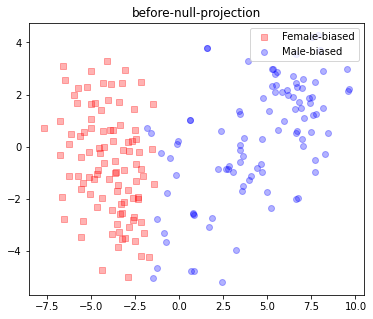

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


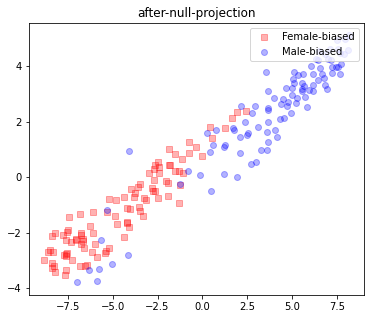

V-measure-before (TSNE space): 0.6069351387610009
V-measure-after (TSNE space): 0.5333833942150723
V-measure-before (original space): 0.778190793392485
V-measure-after (original space): 0.11810684063548854


In [ ]:
debias_effect_analysis(generator, X_test, Y_test)

In [ ]:
generator.cuda()

EMBEDDINGS_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/bert-embeddings.txt"
from gensim.models import KeyedVectors
embed = KeyedVectors.load_word2vec_format(EMBEDDINGS_FILE_PATH, binary=False)

In [ ]:
words = list(embed.vocab.keys())
X = embed.vectors
print(len(words), X.shape)

generator.cuda()
X_after = generator(torch.tensor(X).cuda()).tolist()


with open(f"{GOOGLE_DRIVE_PATH}/processed_embedding.txt", "w") as bert_file:
    bert_file.write(f"9794 768 \n")
    for word, embedding in zip(words, X_after):
        bert_file.write(f"{word} {' '.join(map(str, embedding))}\n")

EMBEDDINGS_FILE_PATH = f"{GOOGLE_DRIVE_PATH}/processed_embedding.txt"
from gensim.models import KeyedVectors
embed = KeyedVectors.load_word2vec_format(EMBEDDINGS_FILE_PATH, binary=False)


9794 (9794, 768)


In [ ]:
def cos_sim(a,b):
    # a, b: numpy.ndarray
    return np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b))

with open(f"{GOOGLE_DRIVE_PATH}/questions-words.txt") as f:
    q_ws = f.readlines()
count = 0
sim_sum = 0
for q_w in q_ws:
    q_w = q_w.split()
    if len(q_w) == 4:
        word1, word2, word3, word4 = q_w   
        if (word1 in embed.vocab) & (word2 in embed.vocab) & (word3 in embed.vocab) & (word4 in embed.vocab):
            count += 1
            a = embed.most_similar(positive=[word1, word4], negative=[word3])[0][0]
            sim_sum += cos_sim(embed[a], embed[word2])

print(count)
sim_sum /= count
print(sim_sum)

3020
0.9993531957564764
